# Hyytiälä 2018 figures for pyAPES 1.0 manuscript

## Load environmental variablesa and set pyAPES into path

In [1]:
import sys
import os
from dotenv import load_dotenv

load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')
hyytiala_forcing = os.getenv('HYYTIALA_FORCING')
lad_data = os.getenv('HYYTIALA_LAD_PROFILES')
hyytiala_data_folder = os.getenv('HYYTIALA_2018_DATA')

sys.path.append(pyAPES_main_folder)

## Imports

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.dates as mdates

from sklearn.metrics import r2_score

from pyAPES.utils.iotools import read_data
from pyAPES_utilities.timeseries_tools import diurnal_cycle

%matplotlib widget

In [3]:
sns.set_context('paper', font_scale=1.5)

## Define constants

In [4]:
MOLAR_MASS_H2O = 18.015 
MOLAR_MASS_CO2 = 44.01

## Load Hyytiälä 2018 simulation data

To produce simdata run Demo_hyytiala_2018.ipynb

In [5]:
simdata = xr.open_dataset('../../results/FiHy2018.nc')

## Load Hyytiälä 2018 Eddy covariance data

In [6]:
# read EC fluxdata
flxdata = read_data(fr'{hyytiala_data_folder}/FIHy_flx_2018.dat', sep=';',
                    start_time=simdata.date[0].values, end_time=simdata.date[-1].values)

## Load Hyytiälä 2018 shoot cuvette data

In [7]:
cuvdata = pd.read_csv(fr'{hyytiala_data_folder}/FiHy_cuv_FFlux2018.425', sep=r'\s+', header=0)  # from https://zenodo.org/records/10360968

cuvdata.replace(-999, np.nan, inplace=True)

cuvdata.rename(columns={
    "yyyy": "year", "mm": "month", "dd": "day", "HH": "hour", "MM": "minute",
    }, inplace=True)
cuvdata["datetime"] = pd.to_datetime(cuvdata[["year", "month", "day", "hour", "minute"]])
cuvdata.set_index("datetime", inplace=True)

# F_H2O unreliable at high RH
cuvdata.loc[cuvdata['RHcuv'] > 85, 'F_H2O'] = np.nan

# unit coversion (from all-sided LAI to one-sided LAI)
cuvdata['F_CO2'] = 2 * cuvdata['F_CO2'] / MOLAR_MASS_CO2  # (umol m-2 s-1)
cuvdata['F_H2O'] = 2 * cuvdata['F_H2O'] / MOLAR_MASS_H2O  # (mmol m-2 s-1)
cuvdata_halfhourly = cuvdata.resample("30min").mean()


In [8]:
# cuvdata_daily = pd.DataFrame(index=cuvdata.resample('1D').mean().index,
#                              columns=['FCO2_mean','FCO2_median','FCO2_std','FCO2_5th','FCO2_25th','FCO2_75th','FCO2_95th',
#                                       'FH2O_mean','FH2O_median','FH2O_std','FH2O_5th','FH2O_25th','FH2O_75th','FH2O_95th'])


In [9]:
# cuvdata_compound = [i.split('_')[0] for i in cuvdata_daily.columns]
# cuvdata_compound= [i[1:] for i in cuvdata_compound]
# operation = [i.split('_')[1] for i in cuvdata_daily.columns]

# for i, (comp, op) in enumerate(zip(cuvdata_compound, operation)):
#     print((i, comp, op))

#     percentile = re.findall(r'\d+', op)
#     if len(percentile) > 0:
#         percentile = int(percentile[0])
#         cuvdata_daily.iloc[:, i] = cuvdata.loc[:, f'F_{comp}'].resample('1D').quantile(percentile/100)
    

In [10]:
i=80  # position in canopy (layer 1...100)
f = simdata['canopy_sunlit_fraction'][:,0,i] / simdata['canopy_sunlit_fraction'][:,0,i].max()  # shoot is fully sunlit at midday
simdata['An_pine_canopytop'] = (simdata['pt_net_co2_sunlit'][:,:,1,i] * f  
                                + simdata['pt_net_co2_shaded'][:,:,1,i] * (1 - f)) 
simdata['E_pine_canopytop'] = 1e3*(simdata['pt_transpiration_sunlit'][:,:,1,i] * f  
                                + simdata['pt_transpiration_shaded'][:,:,1,i] * (1 - f))  

In [12]:
cuv_daily

NameError: name 'cuv_daily' is not defined

In [ ]:
r2_df['measured_CO2']

datetime
2018-04-01   -0.031163
2018-04-03    0.010552
2018-04-04   -0.043508
2018-04-07    0.049588
2018-04-08   -0.009380
                ...   
2018-10-24    0.726915
2018-10-27    0.318347
2018-10-28    0.444448
2018-10-29    0.033888
2018-10-30    0.001943
Name: measured_CO2, Length: 199, dtype: float64

In [ ]:
dry_mask.shape

(199,)

In [ ]:
cuv_daily["CO2_mean"][dry_mask]

datetime
2018-04-11    0.174411
2018-04-12    0.254508
2018-04-13    0.316523
2018-04-14    0.155598
2018-04-15    0.134502
                ...   
2018-10-14    1.918697
2018-10-15    2.076402
2018-10-20    0.398839
2018-10-29    0.033888
2018-10-30    0.001943
Name: CO2_mean, Length: 85, dtype: float64

# Leaf scale modelled and measured CO2 and H2O fluxes

********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********


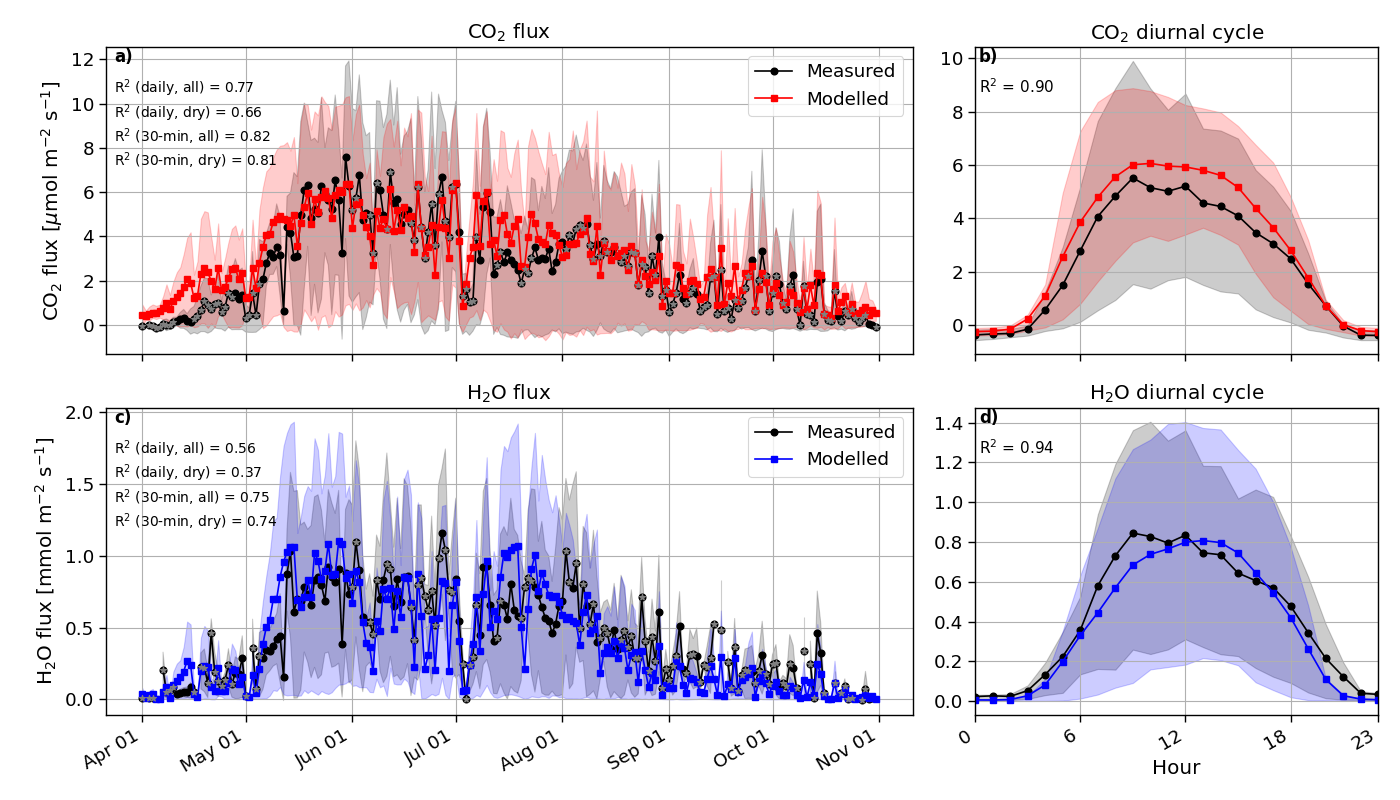

In [23]:
# --- Define time range ---
start_date = pd.Timestamp("2018-04-01 00:00")
end_date = pd.Timestamp("2018-10-31 23:59")

# --- Choose cuvdata from time range ---
cuvdata = cuvdata[(cuvdata.index >= start_date) & (cuvdata.index < end_date)]

# --- Choose simdata from time range---
simdata_apr_oct = simdata.sel(date=slice(start_date, end_date))
simvars = simdata_apr_oct[['An_pine_canopytop','E_pine_canopytop','forcing_precipitation']].isel(simulation=0)
# --- 4. Resamplaus ---
cuv_daily = cuvdata.resample("1D").agg({
    "F_CO2": ["mean", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
    "F_H2O": ["mean", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]
})
cuv_daily.columns = ["CO2_mean", "CO2_q25", "CO2_q75", "H2O_mean", "H2O_q25", "H2O_q75"]
sim_mean = simvars.resample(date="1D").mean()
sim_q25 = simvars.resample(date="1D").reduce(np.percentile, q=25, dim="date")
sim_q75 = simvars.resample(date="1D").reduce(np.percentile, q=75, dim="date")

# --- 5. R$^{2}$ aikasarjoille (KORJATTU NaN käsittely) ---
# Luo DataFrame ilman dropna:ta
r2_df = pd.DataFrame({
    "measured_CO2": cuv_daily["CO2_mean"],
    "model_CO2": sim_mean["An_pine_canopytop"].values,
    "measured_H2O": cuv_daily["H2O_mean"],
    "model_H2O": sim_mean["E_pine_canopytop"].values
})

# Valid maskit erikseen CO2 ja H2O:lle
co2_valid_mask = r2_df["measured_CO2"].notna() & r2_df["model_CO2"].notna()
h2o_valid_mask = r2_df["measured_H2O"].notna() & r2_df["model_H2O"].notna()

# R² daily all
r2_CO2_daily_all = r2_score(r2_df.loc[co2_valid_mask, "measured_CO2"], 
                             r2_df.loc[co2_valid_mask, "model_CO2"])
r2_H2O_daily_all = r2_score(r2_df.loc[h2o_valid_mask, "measured_H2O"], 
                             r2_df.loc[h2o_valid_mask, "model_H2O"])

# Wet canopy mask (daily)
prec_sum_prev_2_days = simvars.forcing_precipitation.resample(date='D').sum().rolling(date=2).sum()
no_rain_mask_daily = (~(prec_sum_prev_2_days > 0) & np.isfinite(prec_sum_prev_2_days)).values.flatten()
wet_mask = ~no_rain_mask_daily
dry_mask = no_rain_mask_daily[:len(r2_df)]
wet_mask = wet_mask[:len(r2_df)]

# R² for dry and wet canopy (daily)
r2_CO2_daily_dry = r2_score(r2_df.loc[co2_valid_mask & dry_mask, "measured_CO2"], 
                             r2_df.loc[co2_valid_mask & dry_mask, "model_CO2"])
r2_H2O_daily_dry = r2_score(r2_df.loc[h2o_valid_mask & dry_mask, "measured_H2O"], 
                             r2_df.loc[h2o_valid_mask & dry_mask, "model_H2O"])
r2_CO2_daily_wet = r2_score(r2_df.loc[co2_valid_mask & wet_mask, "measured_CO2"], 
                             r2_df.loc[co2_valid_mask & wet_mask, "model_CO2"])
r2_H2O_daily_wet = r2_score(r2_df.loc[h2o_valid_mask & wet_mask, "measured_H2O"], 
                             r2_df.loc[h2o_valid_mask & wet_mask, "model_H2O"])

# --- 30-min R$^{2}$ (KORJATTU NaN käsittely) ---
# Align cuvdata_halfhourly with simvars
cuv_30min = cuvdata_halfhourly[(cuvdata_halfhourly.index >= start_date) & (cuvdata_halfhourly.index < end_date)]
# Create DataFrame ilman dropna:ta
r2_df_30min = pd.DataFrame({
    "measured_CO2": cuv_30min["F_CO2"],
    "model_CO2": simvars["An_pine_canopytop"].values,
    "measured_H2O": cuv_30min["F_H2O"],
    "model_H2O": simvars["E_pine_canopytop"].values
})

# Valid maskit erikseen CO2 ja H2O:lle (30-min)
co2_valid_mask_30min = r2_df_30min["measured_CO2"].notna() & r2_df_30min["model_CO2"].notna()
h2o_valid_mask_30min = r2_df_30min["measured_H2O"].notna() & r2_df_30min["model_H2O"].notna()

# R² 30-min all
r2_CO2_30min_all = r2_score(r2_df_30min.loc[co2_valid_mask_30min, "measured_CO2"], 
                             r2_df_30min.loc[co2_valid_mask_30min, "model_CO2"])
r2_H2O_30min_all = r2_score(r2_df_30min.loc[h2o_valid_mask_30min, "measured_H2O"], 
                             r2_df_30min.loc[h2o_valid_mask_30min, "model_H2O"])

# Wet canopy mask (30-min)
prec_sum_30min = simvars.forcing_precipitation.rolling(date=48).sum()
no_rain_mask_30min = (~(prec_sum_30min > 0) & np.isfinite(prec_sum_30min)).values.flatten()
wet_mask_30min = ~no_rain_mask_30min
dry_mask_30min = no_rain_mask_30min[:len(r2_df_30min)]
wet_mask_30min = wet_mask_30min[:len(r2_df_30min)]

# R² 30-min dry and wet
r2_CO2_30min_dry = r2_score(r2_df_30min.loc[co2_valid_mask_30min & dry_mask_30min, "measured_CO2"], 
                             r2_df_30min.loc[co2_valid_mask_30min & dry_mask_30min, "model_CO2"])
r2_H2O_30min_dry = r2_score(r2_df_30min.loc[h2o_valid_mask_30min & dry_mask_30min, "measured_H2O"], 
                             r2_df_30min.loc[h2o_valid_mask_30min & dry_mask_30min, "model_H2O"])
r2_CO2_30min_wet = r2_score(r2_df_30min.loc[co2_valid_mask_30min & wet_mask_30min, "measured_CO2"], 
                             r2_df_30min.loc[co2_valid_mask_30min & wet_mask_30min, "model_CO2"])
r2_H2O_30min_wet = r2_score(r2_df_30min.loc[h2o_valid_mask_30min & wet_mask_30min, "measured_H2O"], 
                             r2_df_30min.loc[h2o_valid_mask_30min & wet_mask_30min, "model_H2O"])

# --- Diurnal cycle ---
dc_meas_CO2 = diurnal_cycle(cuvdata[["F_CO2"]], ap='hour')["F_CO2"]
dc_meas_H2O = diurnal_cycle(cuvdata[["F_H2O"]], ap='hour')["F_H2O"]
dc_mod_CO2 = diurnal_cycle(simvars[["An_pine_canopytop"]].to_dataframe(), ap='hour')["An_pine_canopytop"]
dc_mod_H2O = diurnal_cycle(simvars[["E_pine_canopytop"]].to_dataframe(), ap='hour')["E_pine_canopytop"]

r2_CO2_diurnal = r2_score(dc_meas_CO2["mean"], dc_mod_CO2["mean"])
r2_H2O_diurnal = r2_score(dc_meas_H2O["mean"], dc_mod_H2O["mean"])

# --- Draw figure ---
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1])
ax_ts_CO2 = fig.add_subplot(gs[0, 0])
ax_dc_CO2 = fig.add_subplot(gs[0, 1])
ax_ts_H2O = fig.add_subplot(gs[1, 0])
ax_dc_H2O = fig.add_subplot(gs[1, 1])

dates_meas = cuv_daily.index
dates_mod = sim_mean.date.values

# --- CO2 time series ---
ax_ts_CO2.plot(dates_meas, cuv_daily["CO2_mean"], 'o-', color='black', label='Measured')
ax_ts_CO2.fill_between(dates_meas, cuv_daily["CO2_q25"], cuv_daily["CO2_q75"], color='black', alpha=0.2)
ax_ts_CO2.plot(dates_mod, sim_mean["An_pine_canopytop"], 's-', color='red', label='Modelled')
ax_ts_CO2.fill_between(dates_mod, sim_q25["An_pine_canopytop"], sim_q75["An_pine_canopytop"], color='red', alpha=0.2)
ax_ts_CO2.set_ylabel(r"CO$_2$ flux [$\mu$mol m$^{-2}$ s$^{-1}$]")
ax_ts_CO2.set_title("CO$_2$ flux")
ax_ts_CO2.grid(True)
ax_ts_CO2.legend()
ax_ts_CO2.text(0.01, 0.95, "a)", transform=ax_ts_CO2.transAxes, fontsize=12, fontweight='bold')
ax_ts_CO2.text(0.01, 0.55, 
               f"R$^{{2}}$ (daily, all) = {r2_CO2_daily_all:.2f}\n"
               f"R$^{{2}}$ (daily, dry) = {r2_CO2_daily_dry:.2f}\n"
               #f"R$^{{2}}$ (daily, wet) = {r2_CO2_daily_wet:.2f}\n"
               f"R$^{{2}}$ (30-min, all) = {r2_CO2_30min_all:.2f}\n"
               f"R$^{{2}}$ (30-min, dry) = {r2_CO2_30min_dry:.2f}\n",
               #f"R$^{{2}}$ (30-min, wet) = {r2_CO2_30min_wet:.2f}",
               transform=ax_ts_CO2.transAxes, fontsize=10)

# -- Wet canopy markers for CO2 ---
ax_ts_CO2.scatter(dates_meas[wet_mask], cuv_daily["CO2_mean"][wet_mask],
                  marker='*', color='gray', s=20, label='Wet canopy', zorder=3)

# --- CO2 diurnal cycle ---
ax_dc_CO2.plot(dc_meas_CO2["hour"], dc_meas_CO2["mean"], 'o-', color='black')
ax_dc_CO2.fill_between(dc_meas_CO2["hour"], dc_meas_CO2["25th"], dc_meas_CO2["75th"], color='black', alpha=0.2)
ax_dc_CO2.plot(dc_mod_CO2["hour"], dc_mod_CO2["mean"], 's-', color='red')
ax_dc_CO2.fill_between(dc_mod_CO2["hour"], dc_mod_CO2["25th"], dc_mod_CO2["75th"], color='red', alpha=0.2)
ax_dc_CO2.set_title("CO$_2$ diurnal cycle")
ax_dc_CO2.set_xlim(0, 23)
ax_dc_CO2.grid(True)
ax_dc_CO2.text(0.01, 0.95, "b)", transform=ax_dc_CO2.transAxes, fontsize=12, fontweight='bold')
ax_dc_CO2.text(0.01, 0.85, f"R$^{2}$ = {r2_CO2_diurnal:.2f}", transform=ax_dc_CO2.transAxes, fontsize=11)

# --- H2O time series ---
ax_ts_H2O.plot(dates_meas, cuv_daily["H2O_mean"], 'o-', color='black', label='Measured')
ax_ts_H2O.fill_between(dates_meas, cuv_daily["H2O_q25"], cuv_daily["H2O_q75"], color='black', alpha=0.2)
ax_ts_H2O.plot(dates_mod, sim_mean["E_pine_canopytop"], 's-', color='blue', label='Modelled')
ax_ts_H2O.fill_between(dates_mod, sim_q25["E_pine_canopytop"], sim_q75["E_pine_canopytop"], color='blue', alpha=0.2)
ax_ts_H2O.set_ylabel(r"H$_2$O flux [mmol m$^{-2}$ s$^{-1}$]")
ax_ts_H2O.set_title("H$_2$O flux")
ax_ts_H2O.grid(True)
ax_ts_H2O.legend()
ax_ts_H2O.text(0.01, 0.95, "c)", transform=ax_ts_H2O.transAxes, fontsize=12, fontweight='bold')
ax_ts_H2O.text(0.01, 0.55, 
               f"R$^{{2}}$ (daily, all) = {r2_H2O_daily_all:.2f}\n"
               f"R$^{{2}}$ (daily, dry) = {r2_H2O_daily_dry:.2f}\n"
               #f"R$^{{2}}$ (daily, wet) = {r2_H2O_daily_wet:.2f}\n"
               f"R$^{{2}}$ (30-min, all) = {r2_H2O_30min_all:.2f}\n"
               f"R$^{{2}}$ (30-min, dry) = {r2_H2O_30min_dry:.2f}\n",
               #f"R$^{{2}}$ (30-min, wet) = {r2_H2O_30min_wet:.2f}",
               transform=ax_ts_H2O.transAxes, fontsize=10)

# -- Wet canopy markers for H2O ---
ax_ts_H2O.scatter(dates_meas[wet_mask], cuv_daily["H2O_mean"][wet_mask],
                  marker='*', color='gray', s=20, label='Wet canopy', zorder=3)

# --- H2O diurnal cycle---
ax_dc_H2O.plot(dc_meas_H2O["hour"], dc_meas_H2O["mean"], 'o-', color='black')
ax_dc_H2O.fill_between(dc_meas_H2O["hour"], dc_meas_H2O["25th"], dc_meas_H2O["75th"], color='black', alpha=0.2)
ax_dc_H2O.plot(dc_mod_H2O["hour"], dc_mod_H2O["mean"], 's-', color='blue')
ax_dc_H2O.fill_between(dc_mod_H2O["hour"], dc_mod_H2O["25th"], dc_mod_H2O["75th"], color='blue', alpha=0.2)
ax_dc_H2O.set_title("H$_2$O diurnal cycle")
ax_dc_H2O.set_xlim(0, 23)
ax_dc_H2O.grid(True)
ax_dc_H2O.text(0.01, 0.95, "d)", transform=ax_dc_H2O.transAxes, fontsize=12, fontweight='bold')
ax_dc_H2O.text(0.01, 0.85, f"R$^{2}$ = {r2_H2O_diurnal:.2f}", transform=ax_dc_H2O.transAxes, fontsize=11)

# Format x-axis for time series
ax_ts_H2O.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))


# Diurnaalikierto CO2
ax_dc_CO2.set_xlabel("Hour")
ax_dc_CO2.set_xticks([0, 6, 12, 18, 23])

# Diurnaalikierto H2O
ax_dc_H2O.set_xlabel("Hour")
ax_dc_H2O.set_xticks([0, 6, 12, 18, 23])

fig.autofmt_xdate()

plt.tight_layout()

********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********


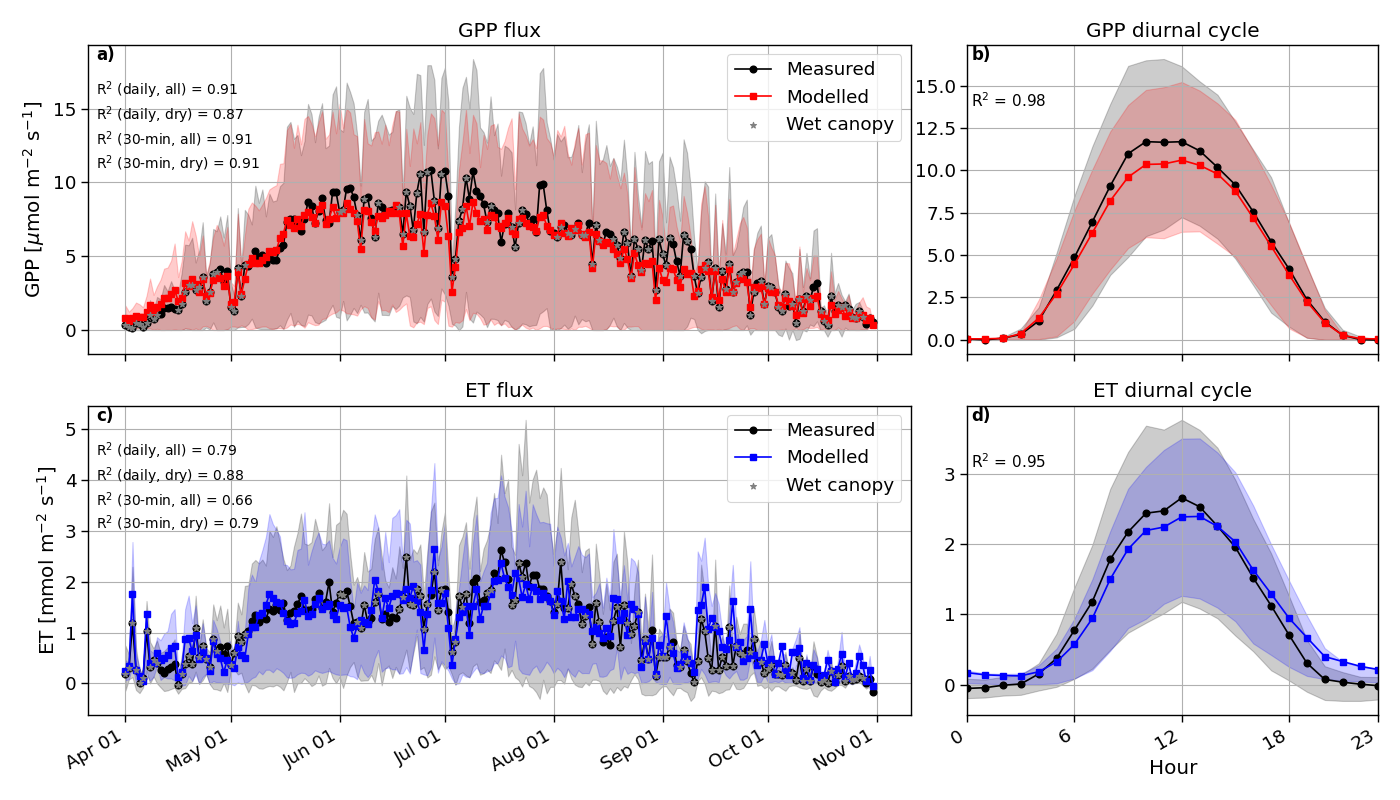

In [14]:
# Select time period
start_date = pd.Timestamp("2018-04-01")
end_date = pd.Timestamp("2018-10-31")

flxdata = flxdata[(flxdata.index >= start_date) & (flxdata.index <= end_date)]
simdata_apr_oct = simdata.sel(date=slice(start_date, end_date))

# Modelled GPP
gpp_model = simdata_apr_oct["pt_total_gpp"].isel(simulation=0).sum(dim="planttype")

# Modelled ET (convert to mmol m-2 s-1)
et_m = simdata_apr_oct["canopy_transpiration"].isel(simulation=0) * 1000  # m s-1 -> kg m-2 s-1
et_total_kg = et_m + simdata_apr_oct["ffloor_evaporation"].isel(simulation=0) + simdata_apr_oct["canopy_evaporation"].isel(simulation=0)
et_model = et_total_kg / (MOLAR_MASS_H2O*1e-3) * 1000  # kg -> mmol

# Daily resampling
flx_daily = flxdata.resample("1D").agg({
    "GPP": ["mean", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
    "ET": ["mean", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]
})
flx_daily.columns = ["GPP_mean", "GPP_q25", "GPP_q75", "ET_mean", "ET_q25", "ET_q75"]

gpp_mean = gpp_model.resample(date="1D").mean()
gpp_q25 = gpp_model.resample(date="1D").reduce(np.percentile, q=25, dim="date")
gpp_q75 = gpp_model.resample(date="1D").reduce(np.percentile, q=75, dim="date")

et_mean = et_model.resample(date="1D").mean()
et_q25 = et_model.resample(date="1D").reduce(np.percentile, q=25, dim="date")
et_q75 = et_model.resample(date="1D").reduce(np.percentile, q=75, dim="date")

# R$^{2}$ for daily time series (KORJATTU NaN käsittely)
# Luo DataFrame ilman dropna:ta
r2_df = pd.DataFrame({
    "measured_GPP": flx_daily["GPP_mean"],
    "model_GPP": gpp_mean.values,
    "measured_ET": flx_daily["ET_mean"],
    "model_ET": et_mean.values
})

# Valid maskit erikseen GPP ja ET:lle
gpp_valid_mask = r2_df["measured_GPP"].notna() & r2_df["model_GPP"].notna()
et_valid_mask = r2_df["measured_ET"].notna() & r2_df["model_ET"].notna()

# R² daily all
r2_GPP = r2_score(r2_df.loc[gpp_valid_mask, "measured_GPP"], 
                  r2_df.loc[gpp_valid_mask, "model_GPP"])
r2_ET = r2_score(r2_df.loc[et_valid_mask, "measured_ET"], 
                 r2_df.loc[et_valid_mask, "model_ET"])

# Wet canopy mask (daily)
prec_sum_prev_2_days = simdata_apr_oct.forcing_precipitation.resample(date='D').sum().rolling(date=2).sum()
no_rain_mask_daily = (~(prec_sum_prev_2_days > 0) & np.isfinite(prec_sum_prev_2_days)).values.flatten()
wet_mask = ~no_rain_mask_daily
dry_mask = no_rain_mask_daily[:len(r2_df)]
wet_mask = wet_mask[:len(r2_df)]

# R$^{2}$ for dry canopy (daily)
r2_GPP_dry = r2_score(r2_df.loc[gpp_valid_mask & dry_mask, "measured_GPP"], 
                      r2_df.loc[gpp_valid_mask & dry_mask, "model_GPP"])
r2_ET_dry = r2_score(r2_df.loc[et_valid_mask & dry_mask, "measured_ET"], 
                     r2_df.loc[et_valid_mask & dry_mask, "model_ET"])

# Wet canopy mask (30-min)
prec_sum_30min = simdata_apr_oct.forcing_precipitation.rolling(date=48).sum()
no_rain_mask_30min = (~(prec_sum_30min > 0) & np.isfinite(prec_sum_30min)).values.flatten()
wet_mask_30min = ~no_rain_mask_30min
dry_mask_30min = no_rain_mask_30min

# R$^{2}$ for 30-min time step (KORJATTU NaN käsittely)
# Luo DataFrame ilman dropna:ta
r2_df_30min = pd.DataFrame({
    "measured_GPP": flxdata["GPP"],
    "model_GPP": gpp_model.values,
    "measured_ET": flxdata["ET"],
    "model_ET": et_model.values
})

# Valid maskit erikseen GPP ja ET:lle (30-min)
gpp_valid_mask_30min = r2_df_30min["measured_GPP"].notna() & r2_df_30min["model_GPP"].notna()
et_valid_mask_30min = r2_df_30min["measured_ET"].notna() & r2_df_30min["model_ET"].notna()

# R² 30-min all
r2_GPP_30min_all = r2_score(r2_df_30min.loc[gpp_valid_mask_30min, "measured_GPP"], 
                             r2_df_30min.loc[gpp_valid_mask_30min, "model_GPP"])
r2_ET_30min_all = r2_score(r2_df_30min.loc[et_valid_mask_30min, "measured_ET"], 
                            r2_df_30min.loc[et_valid_mask_30min, "model_ET"])

# Adjust mask lengths for 30-min data
dry_mask_30min = dry_mask_30min[:len(r2_df_30min)]
wet_mask_30min = wet_mask_30min[:len(r2_df_30min)]

# R² 30-min dry
r2_GPP_30min_dry = r2_score(r2_df_30min.loc[gpp_valid_mask_30min & dry_mask_30min, "measured_GPP"], 
                             r2_df_30min.loc[gpp_valid_mask_30min & dry_mask_30min, "model_GPP"])
r2_ET_30min_dry = r2_score(r2_df_30min.loc[et_valid_mask_30min & dry_mask_30min, "measured_ET"], 
                            r2_df_30min.loc[et_valid_mask_30min & dry_mask_30min, "model_ET"])

# Diurnal cycles
dc_meas_GPP = diurnal_cycle(flxdata[["GPP"]], ap='hour')["GPP"]
dc_meas_ET = diurnal_cycle(flxdata[["ET"]], ap='hour')["ET"]
dc_mod_GPP = diurnal_cycle(gpp_model.to_dataframe(name='GPP_model'), ap='hour')['GPP_model']
dc_mod_ET = diurnal_cycle(et_model.to_dataframe(name='ET_model'), ap='hour')['ET_model']

r2_GPP_diurnal = r2_score(dc_meas_GPP["mean"], dc_mod_GPP["mean"])
r2_ET_diurnal = r2_score(dc_meas_ET["mean"], dc_mod_ET["mean"])

# Plot figure
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1])
ax_ts_GPP = fig.add_subplot(gs[0, 0])
ax_dc_GPP = fig.add_subplot(gs[0, 1])
ax_ts_ET = fig.add_subplot(gs[1, 0])
ax_dc_ET = fig.add_subplot(gs[1, 1])

dates_meas = flx_daily.index
dates_mod = gpp_mean.date.values

# Time series GPP
ax_ts_GPP.plot(dates_meas, flx_daily["GPP_mean"], 'o-', color='black', label='Measured', zorder=2)
ax_ts_GPP.fill_between(dates_meas, flx_daily["GPP_q25"], flx_daily["GPP_q75"], color='black', alpha=0.2, zorder=1)
ax_ts_GPP.plot(dates_mod, gpp_mean, 's-', color='red', label='Modelled', zorder=2)
ax_ts_GPP.fill_between(dates_mod, gpp_q25, gpp_q75, color='red', alpha=0.2, zorder=1)

# Wet canopy markers
ax_ts_GPP.scatter(dates_meas[wet_mask], flx_daily["GPP_mean"][wet_mask],
                  marker='*', color='gray', s=20, label='Wet canopy', zorder=3)

ax_ts_GPP.set_ylabel(r"GPP [$\mu$mol m$^{-2}$ s$^{-1}$]")
ax_ts_GPP.set_title("GPP flux")
ax_ts_GPP.grid(True)
ax_ts_GPP.legend()

# Subplot label and R$^{2}$ text
ax_ts_GPP.text(0.01, 0.95, "a)", transform=ax_ts_GPP.transAxes, fontsize=12, fontweight='bold')
ax_ts_GPP.text(0.01, 0.6,
               f"R$^{2}$ (daily, all) = {r2_GPP:.2f}\n"
               f"R$^{2}$ (daily, dry) = {r2_GPP_dry:.2f}\n"
               f"R$^{2}$ (30-min, all) = {r2_GPP_30min_all:.2f}\n"
               f"R$^{2}$ (30-min, dry) = {r2_GPP_30min_dry:.2f}",
               transform=ax_ts_GPP.transAxes, fontsize=10)

# Diurnal cycle GPP
ax_dc_GPP.plot(dc_meas_GPP["hour"], dc_meas_GPP["mean"], 'o-', color='black')
ax_dc_GPP.fill_between(dc_meas_GPP["hour"], dc_meas_GPP["25th"], dc_meas_GPP["75th"], color='black', alpha=0.2)
ax_dc_GPP.plot(dc_mod_GPP["hour"], dc_mod_GPP["mean"], 's-', color='red')
ax_dc_GPP.fill_between(dc_mod_GPP["hour"], dc_mod_GPP["25th"], dc_mod_GPP["75th"], color='red', alpha=0.2)
ax_dc_GPP.set_title("GPP diurnal cycle")
ax_dc_GPP.set_xlim(0, 23)
ax_dc_GPP.grid(True)
ax_dc_GPP.text(0.01, 0.95, "b)", transform=ax_dc_GPP.transAxes, fontsize=12, fontweight='bold')
ax_dc_GPP.text(0.01, 0.80, f"R$^{2}$ = {r2_GPP_diurnal:.2f}", transform=ax_dc_GPP.transAxes, fontsize=11)

# Time series ET
ax_ts_ET.plot(dates_meas, flx_daily["ET_mean"], 'o-', color='black', label='Measured', zorder=2)
ax_ts_ET.fill_between(dates_meas, flx_daily["ET_q25"], flx_daily["ET_q75"], color='black', alpha=0.2, zorder=1)
ax_ts_ET.plot(dates_mod, et_mean, 's-', color='blue', label='Modelled', zorder=2)
ax_ts_ET.fill_between(dates_mod, et_q25, et_q75, color='blue', alpha=0.2, zorder=1)

# Wet canopy markers
ax_ts_ET.scatter(dates_meas[wet_mask], flx_daily["ET_mean"][wet_mask],
                 marker='*', color='gray', s=20, label='Wet canopy', zorder=3)

ax_ts_ET.set_ylabel(r"ET [mmol m$^{-2}$ s$^{-1}$]")
ax_ts_ET.set_title("ET flux")
ax_ts_ET.grid(True)
ax_ts_ET.legend()

# Subplot label and R$^{2}$ text
ax_ts_ET.text(0.01, 0.95, "c)", transform=ax_ts_ET.transAxes, fontsize=12, fontweight='bold')
ax_ts_ET.text(0.01, 0.6,
              f"R$^{2}$ (daily, all) = {r2_ET:.2f}\n"
              f"R$^{2}$ (daily, dry) = {r2_ET_dry:.2f}\n"
              f"R$^{2}$ (30-min, all) = {r2_ET_30min_all:.2f}\n"
              f"R$^{2}$ (30-min, dry) = {r2_ET_30min_dry:.2f}",
              transform=ax_ts_ET.transAxes, fontsize=10)

# Diurnal cycle ET
ax_dc_ET.plot(dc_meas_ET["hour"], dc_meas_ET["mean"], 'o-', color='black')
ax_dc_ET.fill_between(dc_meas_ET["hour"], dc_meas_ET["25th"], dc_meas_ET["75th"], color='black', alpha=0.2)
ax_dc_ET.plot(dc_mod_ET["hour"], dc_mod_ET["mean"], 's-', color='blue')
ax_dc_ET.fill_between(dc_mod_ET["hour"], dc_mod_ET["25th"], dc_mod_ET["75th"], color='blue', alpha=0.2)
ax_dc_ET.set_title("ET diurnal cycle")
ax_dc_ET.set_xlim(0, 23)
ax_dc_ET.grid(True)
ax_dc_ET.text(0.01, 0.95, "d)", transform=ax_dc_ET.transAxes, fontsize=12, fontweight='bold')
ax_dc_ET.text(0.01, 0.80, f"R$^{2}$ = {r2_ET_diurnal:.2f}", transform=ax_dc_ET.transAxes, fontsize=11)

# Format x-axis for time series
ax_ts_ET.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Diurnal cycle axes
ax_dc_GPP.set_xlabel("Hour")
ax_dc_GPP.set_xticks([0, 6, 12, 18, 23])
ax_dc_ET.set_xlabel("Hour")
ax_dc_ET.set_xticks([0, 6, 12, 18, 23])

fig.autofmt_xdate()
plt.tight_layout()

In [16]:
((flx_daily['ET_mean'][~dry_mask] - et_mean[~dry_mask])/flx_daily['ET_mean'][~dry_mask]*100).mean()

np.float64(-124.53685564166967)

In [17]:
((flx_daily['ET_mean'][dry_mask] - et_mean[dry_mask])/flx_daily['ET_mean'][dry_mask]*100).mean()

np.float64(-8.141900450481446)

In [18]:
((flx_daily['ET_mean'] - et_mean)/flx_daily['ET_mean']*100).mean()

np.float64(-77.7613129012856)

In [19]:
((flx_daily['GPP_mean'][~dry_mask] - gpp_mean[~dry_mask])/flx_daily['GPP_mean'][~dry_mask]*100).mean()

np.float64(-9.30228438237128)

In [20]:
((flx_daily['GPP_mean'][dry_mask] - gpp_mean[dry_mask])/flx_daily['GPP_mean'][dry_mask]*100).mean()

np.float64(2.629042491053426)

In [21]:
((flx_daily['GPP_mean'] - gpp_mean)/flx_daily['GPP_mean']*100).mean()

np.float64(-4.507452087443593)